In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.6 MB/s 
     |████████████████████████████████| 182 kB 73.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.3 MB/s 


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("arize-ai/resnet-50-fashion-mnist-quality-drift")

model = AutoModelForImageClassification.from_pretrained("arize-ai/resnet-50-fashion-mnist-quality-drift")

Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/926 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

In [ ]:
extractor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

(28, 28)


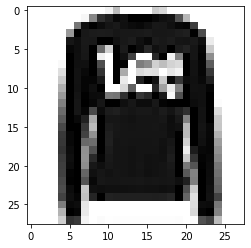

In [ ]:
img = test_images[1]
print(img.shape)
plt.imshow(img,cmap=plt.cm.binary)
plt.show()

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=extractor.image_mean, std=extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [ ]:
%pip install -q datasets transformers
from datasets import load_dataset 

dataset = load_dataset("fashion_mnist")

     |████████████████████████████████| 451 kB 7.0 MB/s 
     |████████████████████████████████| 132 kB 62.8 MB/s 
     |████████████████████████████████| 212 kB 77.6 MB/s 
     |████████████████████████████████| 127 kB 69.4 MB/s 


Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-11-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
dataset = dataset.with_transform(transforms)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    "abhishek/autotrain_fashion_mnist_vit_base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
model_checkpoint='abhishek/autotrain_fashion_mnist_vit_base'
batch_size = 32 

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=extractor,
    compute_metrics=compute_metrics
)


In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2340
  Number of trainable parameters = 85806346


Epoch,Training Loss,Validation Loss,Accuracy
0,0.340600,0.389983,0.858500
1,0.304600,0.347949,0.874900
2,0.284600,0.330627,0.880200
3,0.250300,0.311458,0.890500
4,0.220200,0.297372,0.891400


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-468
Configuration saved in ./results/checkpoint-468/config.json
Model weights saved in ./results/checkpoint-468/pytorch_model.bin
Image processor saved in ./results/checkpoint-468/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-936
Configuration saved in ./results/checkpoint-936/config.json
Model weights saved in ./results/checkpoint-936/pytorch_model.bin
Image processor saved in ./results/checkpoint-936/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1404
Configuration saved in ./results/checkpoint-1404/config.json
Model weights saved in ./results/checkpoint-1404/pytorch_model.bin
Image processor saved in ./results/checkpoint-1404/preprocessor_config.json
***** Running Evaluat

***** train metrics *****
  epoch                    =           5.0
  total_flos               = 21645635372GF
  train_loss               =        0.4093
  train_runtime            =    2:58:02.59
  train_samples_per_second =        28.083
  train_steps_per_second   =         0.219


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.892
  eval_loss               =     0.3048
  eval_runtime            = 0:02:14.02
  eval_samples_per_second =     74.614
  eval_steps_per_second   =      2.335


In [ ]:
trainer.save_model("model.json")

Saving model checkpoint to model.json
Configuration saved in model.json/config.json
Model weights saved in model.json/pytorch_model.bin
Image processor saved in model.json/preprocessor_config.json
